# GAN with MNIST

## model

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
img_shape = (1, 28, 28)
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

### pare GPU

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
!nvidia-smi

cuda = True if torch.cuda.is_available() else False

True
1
Tue Feb 28 02:17:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    25W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

### datasets

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([1, 28, 28])
7


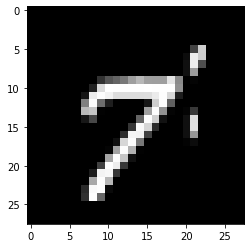

In [4]:
dataloader = torch.utils.data.DataLoader(
    dataset=datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# show a example data
index = 10

dataiter = iter(dataloader)
(img, label) = next(dataiter)

print(img[0].shape)
print(label[index].item())

plt.imshow(img[index].squeeze(), cmap='gray')

## define hyperparameter

In [5]:
learning_rate = 0.0002
num_epoch = 200
sample_interval = 400
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
b1 = 0.5
b2 = 0.999

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))

In [7]:
Generator_PATH = './Gmodel'
Discriminator_PATH = './Dmodel'

# generator.load_state_dict(torch.load(Generator_PATH))
# discriminator.load_state_dict(torch.load(Discriminator_PATH))

In [ ]:
for epoch in range(num_epoch):
    if epoch % 10 == 0:
      print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, num_epoch,  d_loss.item(), g_loss.item())
        )
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        # if batches_done % sample_interval== 0:
        #     save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)


torch.save(generator.state_dict(), Generator_PATH)
torch.save(discriminator.state_dict(), Discriminator_PATH)

## test

torch.Size([1, 28, 28])


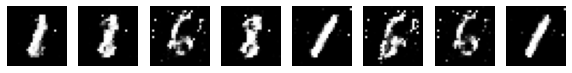

In [33]:
with torch.no_grad():
  # Sample noise as generator input
  z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

  # Generate a batch of images
  gen_imgs = generator(z)
  gen_imgs = gen_imgs.cpu()

  print(gen_imgs[0].shape)

  fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(10,5))

  for i, ax in enumerate(axes):
      ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
      ax.axis('off')
